In [ ]:
import pandas as pd
import networkx as nx
try:
    data_raw = pd.read_csv('/content/amazon_reviews.csv' , nrows=1000)
except pd.errors.ParserError:
    data_raw = pd.read_csv('/content/amazon_reviews.csv', error_bad_lines=False)

print(data_raw.columns)
data = data_raw


Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')


Text Preocessing for the description

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocessing(text):
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

columns_to_process = ['description', 'summary', 'reviewText']
for column in columns_to_process:
    data[column + '_processed'] = data[column].apply(lambda x: text_preprocessing(x) if pd.notnull(x) else '')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


converting categorical data into numerical data



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['verified', 'brand', 'category', 'itemName', 'userName']

# Initialize LabelEncoders for each column
label_encoders = {}

for col in columns_to_encode:
    if col == 'itemName':
        # If the column is 'itemName', encode and drop duplicates
        label_encoder = LabelEncoder()
        data[col + '_encoded'] = label_encoder.fit_transform(data[col])
        data = data.drop_duplicates(subset=[col + '_encoded'])
    else:
        # For other columns, just encode
        label_encoder = LabelEncoder()
        data[col + '_encoded'] = label_encoder.fit_transform(data[col])

    # Save the label encoder for potential future use (e.g., inverse_transform)
    label_encoders[col] = label_encoder

<ipython-input-9-38d8dd2d9566>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_encoded'] = label_encoder.fit_transform(data[col])


In [ ]:
print(data.columns)
top_5_values_before = data[['verified', 'brand', 'category', 'itemName']].head(5)
print(top_5_values_before)
top_5_values = data[['userName_encoded','verified_encoded', 'brand_encoded', 'category_encoded', 'itemName_encoded']].head(5)
print(top_5_values)

Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote', 'verified_encoded', 'brand_encoded',
       'category_encoded', 'itemName_encoded', 'userName_encoded'],
      dtype='object')
   verified            brand                  category  \
0      True        Toblerone              Prime_Pantry   
1      True  Prince Of Peace  Grocery_and_Gourmet_Food   
2      True     Pet Champion              Pet_Supplies   
3     False       KOH-I-NOOR    Arts_Crafts_and_Sewing   
4      True           Parker           Office_Products   

                                            itemName  
0  Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...  
1  Prince of Peace Organic Tea, Oolong, 100 Tea Bags  
2  Pet Champion Adjustable No-Pull Harness, Colla...  
3  Koh-I-Noor Progresso Woodless Colored 24-Penci...  
4  Parker Urban Premium Ebony Metal Chiseled, Bal...  
   userName_enc

label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['brand_encoded'] = label_encoder.fit_transform(data['brand'].astype(str))


<ipython-input-11-fb8f0ada2ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand_encoded'] = label_encoder.fit_transform(data['brand'].astype(str))


data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data['price'] = pd.to_numeric(data['price'].replace({'\$': '', ',': '', '^[^\d\.]': '0'}, regex=True), errors='coerce').fillna(0)

scaler = MinMaxScaler()
data['price_scaled'] = scaler.fit_transform(data[['price']])


<ipython-input-12-f59d485acff9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = pd.to_numeric(data['price'].replace({'\$': '', ',': '', '^[^\d\.]': '0'}, regex=True), errors='coerce').fillna(0)
<ipython-input-12-f59d485acff9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_scaled'] = scaler.fit_transform(data[['price']])


In [ ]:
data['price_scaled'] = data['price_scaled'].replace('[\$,]', '', regex=True).astype(float)

price_ranges = data.groupby('category')['price_scaled'].agg(['min', 'max'])

print(price_ranges)

                                  min       max
category                                       
Arts_Crafts_and_Sewing       0.000000  0.091301
Cell_Phones_and_Accessories  0.000000  0.469927
Grocery_and_Gourmet_Food     0.000000  0.121739
Office_Products              0.000000  0.365248
Patio_Lawn_and_Garden        0.000000  1.000000
Pet_Supplies                 0.000000  0.250753
Prime_Pantry                 0.002481  0.011399
Video_Games                  0.000000  0.121724


<ipython-input-13-5605735aead1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price_scaled'] = data['price_scaled'].replace('[\$,]', '', regex=True).astype(float)


In [ ]:
import pandas as pd

user_ratings_count = data['userName_encoded'].value_counts()

# Filter users with less than 5 ratings
users_with_less_than_5_ratings = user_ratings_count[user_ratings_count < 5].index
print("Number of rows before filtering:", len(data))

data = data[~data['userName_encoded'].isin(users_with_less_than_5_ratings)]

print("Number of rows after filtering:", len(data))

Number of rows before filtering: 834
Number of rows after filtering: 137


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

grouped_data = data.groupby('userName_encoded')

train_set = pd.DataFrame()
test_set = pd.DataFrame()

# Iterate over each group (user)
for user, group in grouped_data:
    # Split each user's items into train and test sets
    user_train, user_test = train_test_split(group, test_size=0.2, random_state=42)

    # Concatenate the splits to the overall train and test sets
    train_set = pd.concat([train_set, user_train])
    test_set = pd.concat([test_set, user_test])

# Print the shapes of the resulting train and test sets
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)


Train set shape: (1935, 20)
Test set shape: (605, 20)


In [ ]:
#X_train, X_test = train_test_split(data, test_size=0.05, shuffle=False)
data[:int(len(data)*0.8)].to_csv('xtrain.csv', index=False)
data[int(len(data)*0.8):].to_csv('xtest.csv', index=False)

X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')
print(X_train.shape)
print(X_test.shape)

(800, 23)
(200, 23)


**Birpatite Graph: Graph Based recommendation system**




Number of nodes: 834
Number of edges: 706


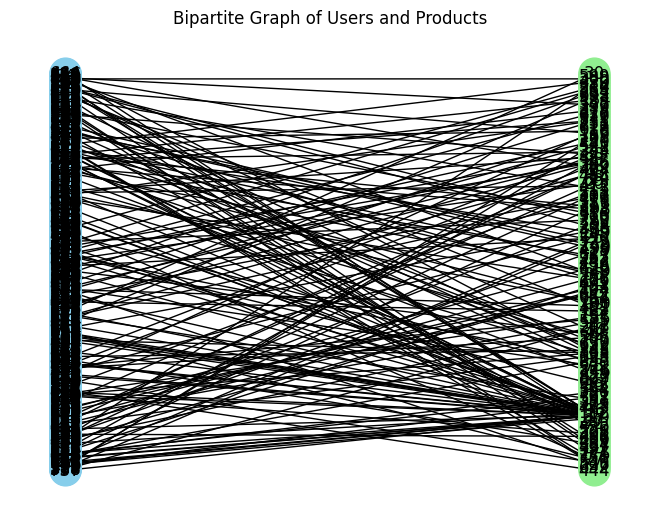

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

df = data_raw
# Encode userName and itemName
df['user_id'] = df['userName'].astype('category').cat.codes
df['product_id'] = df['itemName'].astype('category').cat.codes


favorable_reviews_df = df[df['rating'] >= 3.5]

favorable_reviews_df = df[df['rating'] >= 3.5]
G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(df['product_id'], bipartite=0)  # Products
G.add_nodes_from(favorable_reviews_df['user_id'], bipartite=1)  # Users

# Add edges
for _, row in favorable_reviews_df.iterrows():
    G.add_edge(row['user_id'], row['product_id'])
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

pos = nx.bipartite_layout(G, nodes=favorable_reviews_df['product_id'].unique())
nx.draw(G, pos, with_labels=True, node_color=['skyblue' if n in favorable_reviews_df['product_id'].unique() else 'lightgreen' for n in G], node_size=500)
plt.title("Bipartite Graph of Users and Products")
plt.show()

In [ ]:
!pip install gensim


In [ ]:
!pip install node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from node2vec import Node2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, workers=4, p=1, q=2)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Step 2: Get product embeddings
product_ids = [node for node, data in G.nodes(data=True) if data['bipartite'] == 0]
product_embeddings = np.array([model.wv[str(product_id)] for product_id in product_ids])




Computing transition probabilities:   0%|          | 0/834 [00:00<?, ?it/s]

In [ ]:
product_embeddings

array([[ 1.8482479e-01, -1.6630405e-01,  3.1061819e-01, ...,
         3.4017775e-03,  3.2750991e-01,  2.1316091e-02],
       [ 8.8683441e-03,  9.4514340e-05,  1.0808598e-02, ...,
         1.4509443e-02, -2.1414924e-03,  2.0454340e-03],
       [ 6.0519999e-01, -1.2160158e+00,  6.1866081e-01, ...,
         7.5003099e-01,  4.5780700e-01,  6.8479878e-01],
       ...,
       [ 1.2115356e-01, -2.5308269e-01,  2.3955965e-01, ...,
        -9.9485122e-02,  2.9034525e-01,  2.9672014e-02],
       [-7.1088314e-01, -3.9442083e-01,  9.0405755e-02, ...,
        -3.2556137e-01, -2.4869044e-01,  9.4916904e-01],
       [ 7.1135443e-01, -1.0994583e+00, -3.4163588e-01, ...,
         3.9921838e-01,  5.6131852e-01,  1.1804677e+00]], dtype=float32)

In [ ]:
product_embeddings_normalized = product_embeddings / np.linalg.norm(product_embeddings, axis=1, keepdims=True)
product_embeddings_normalized

array([[ 0.06176934, -0.05557962,  0.10381011, ...,  0.00113689,
         0.1094554 ,  0.00712394],
       [ 0.11582451,  0.0012344 ,  0.1411651 , ...,  0.18949977,
        -0.02796884,  0.02671427],
       [ 0.10660761, -0.21420446,  0.10897876, ...,  0.13211997,
         0.08064394,  0.12062915],
       ...,
       [ 0.04074213, -0.08510793,  0.08056033, ..., -0.03345536,
         0.09763877,  0.00997826],
       [-0.1451116 , -0.08051258,  0.0184544 , ..., -0.0664564 ,
        -0.05076484,  0.19375257],
       [ 0.12522283, -0.19354247, -0.06013966, ...,  0.07027616,
         0.09881136,  0.2078029 ]], dtype=float32)

In [ ]:
cosine_sim_matrix = cosine_similarity(product_embeddings_normalized)
cosine_sim_matrix

array([[ 1.        , -0.15897794,  0.30747467, ...,  0.9834368 ,
         0.34070852,  0.290884  ],
       [-0.15897794,  1.        ,  0.06369592, ..., -0.18358053,
        -0.31143734, -0.15735975],
       [ 0.30747467,  0.06369592,  1.0000002 , ...,  0.28796458,
         0.46645477,  0.52831346],
       ...,
       [ 0.9834368 , -0.18358053,  0.28796458, ...,  1.0000002 ,
         0.3361122 ,  0.2899895 ],
       [ 0.34070852, -0.31143734,  0.46645477, ...,  0.3361122 ,
         1.0000004 ,  0.5213199 ],
       [ 0.290884  , -0.15735975,  0.52831346, ...,  0.2899895 ,
         0.5213199 ,  1.        ]], dtype=float32)

In [ ]:

def get_recommendations_for_user(user_id, similarity_matrix, product_ids, df, rec_size=5):
    # Step 1: Retrieve the set of products (Pu) that the target user has reviewed
    Pu = set(df[df['user_id'] == user_id]['product_id'])
    print(Pu)
    # Step 2: Filter out products already reviewed by the target user from the recommendation set
    filtered_recommendations = [product_id for product_id in product_ids if product_id not in Pu]

    # Step 3: Aggregate similarity scores for each product in Pu
    Pu_recommended = {}
    for product_id in Pu:
        if product_id in product_ids:
            product_index = product_ids.index(product_id)
            product_similarities = similarity_matrix[product_index]

            # Step 4: Find the top 10 most similar products
            top_similar_products = sorted(range(len(product_similarities)), key=lambda i: product_similarities[i], reverse=True)[:]

            # Step 5: Aggregate similarity scores across all products in Pu
            for similar_product_index in top_similar_products:
                similar_product_id = product_ids[similar_product_index]
                if similar_product_id not in Pu:
                    if similar_product_id not in Pu_recommended:
                        Pu_recommended[similar_product_id] = 0
                    Pu_recommended[similar_product_id] += product_similarities[similar_product_index]

    # Step 6: Sort Purecommended by updated similarity scores
    sorted_recommendations = sorted(Pu_recommended.keys(), key=lambda x: Pu_recommended[x], reverse=True)

    # Step 7: Return the top |rec_size| products as the recommendation set
    final_recommendations = sorted_recommendations[:rec_size]

    return final_recommendations

In [ ]:
user_id = 17
recommendation_set = get_recommendations_for_user(user_id, cosine_sim_matrix, product_ids, df)
product_categories = df['itemName'].astype('category').cat.categories
categories = df['category']

recommended_item_names = [product_categories[i] for i in recommendation_set]
recommended_category = [categories[i] for i in recommendation_set]


from tabulate import tabulate

# Assuming recommended_item_names and recommendation_set are lists of values
data = {'Item Names': recommended_item_names, 'Product ID': recommendation_set, 'Category' : recommended_category}
table = tabulate(data, headers='keys', tablefmt='pretty', showindex=False)

print(table)

{644, 390, 136, 8, 654, 787, 148, 407, 663, 665, 539, 414, 676, 677, 40, 558, 824, 441, 316, 61, 830, 453, 458, 714, 463, 592, 725, 470, 730, 734, 737, 356, 357, 231, 746, 621, 370, 627, 498, 638}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------+
|                                                                                                Item Names                                                                                                | Product ID |       Category        |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+-----------------------+
|                                                                            

In [ ]:
from prettytable import PrettyTable
filtered_data1 = df[df['user_id'] == 17]
if not filtered_data1.empty:

      display_data = filtered_data1[['product_id', 'itemName', 'category']]

      # Convert the DataFrame to a table format
      table = tabulate(display_data, headers='keys', tablefmt='pretty', showindex=False)

      # Print the table
      print(table)

+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+
| product_id |                                                                                           itemName                                                                                            |          category           |
+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+
|    737     |                                                             Toblerone Swiss Milk Chocolate Bar, Crunchy Salted Almond, 3.52 Ounce                                                             |        Prime_Pantry         |
|    663     |                                      

In [ ]:
def user_products(user):
  import pandas as pd

  user_id = 17

  filtered_data = df[df['user_id'] == user_id]
  category_counts = filtered_data['category'].value_counts()

  return category_counts

user_products(3228)

Pet_Supplies                   15
Office_Products                 9
Cell_Phones_and_Accessories     9
Patio_Lawn_and_Garden           9
Grocery_and_Gourmet_Food        3
Prime_Pantry                    1
Name: category, dtype: int64

In [ ]:
import pandas as pd

from tabulate import tabulate
from tabulate import tabulate

def remove_items_for_users(df, user_ids):
    temp_df = df.copy()
    for user_id in user_ids:
        filtered_data = df[df['user_id'] == user_id]

        if not filtered_data.empty:
            reviews_to_remove = filtered_data.head(5)

            temp_df = temp_df.drop(reviews_to_remove.index)

    return temp_df

# Example usage:
user_ids_to_remove = df['user_id'].head(10)
temp_df = remove_items_for_users(df, user_ids_to_remove)


In [ ]:
temp_df.shape

(9966, 20)

In [ ]:
from sklearn.model_selection import train_test_split

precision_list = []
recall_list = []
unique_users = df['user_id'].head(10)
unique_items = df['user_id'].unique()


for user in unique_users:
    user_data = test_data[test_data['user_id'] == user]

    recommended_items = get_recommendations_for_user(user, cosine_sim_matrix, product_ids, df)
    category = df['category']

    recommended_category = [category[i] for i in recommendation_set]

    # Calculate true positives, false positives, and false negatives
    true_positives = len(set(user_data['category']) & set(recommended_category))
    false_positives = len(set(recommended_category) - set(user_data['category']))
    false_negatives = len(set(user_data['category']) - set(recommended_category))

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


    precision_list.append(precision)
    recall_list.append(recall)

# Calculate average precision and recall
average_precision = sum(precision_list) / len(precision_list)
average_recall = sum(recall_list) / len(recall_list)
average_f1_score = 2 * (average_precision * average_recall) / (average_precision + average_recall) if (average_precision + average_recall) > 0 else 0



print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')
print(f'Average F1 Score: {average_f1_score}')


{644, 390, 136, 8, 654, 787, 148, 407, 663, 665, 539, 414, 676, 677, 40, 558, 824, 441, 316, 61, 830, 453, 458, 714, 463, 592, 725, 470, 730, 734, 737, 356, 357, 231, 746, 621, 370, 627, 498, 638}
{474, 578}
{536, 511}
{387}
{517, 519}
{444}
{112, 593, 113}
{658, 692}
{761, 526}
{549}
Average Precision: 0.125
Average Recall: 0.275
Average F1 Score: 0.171875
